In [53]:
import torch
from torch import nn
from torch.nn import parameter
from d2l import torch as d2l
import torchvision
import numpy as np
import pandas as pd

In [54]:
train_data = pd.read_csv('../data/kaggle-house-california/train.csv')
test_data = pd.read_csv('../data/kaggle-house-california/test.csv')

In [55]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [56]:
all_features = pd.concat(axis=0, objs=[train_data.iloc[:,1:], test_data])
all_features.drop(columns=['Summary', 'Id', 'Zip', 'Summary','Elementary School', 'Middle School', 'High School', 'Listed On', 'Last Sold On', 'Address', 'Parking features'], inplace=True)
# features

In [57]:
# 处理bedroom的数据
def transform_non_numeric(value):
    if not isinstance(value, str) or value.isnumeric():
        return float(value)
    else:
        comma_count = value.count(',')
        return comma_count + 1
all_features['Bedrooms'] = all_features['Bedrooms'].apply(transform_non_numeric)

In [58]:
# 处理数字
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [59]:
# 处理parking的数据
def process_parking_column(df):
    df['Parking'] = df['Parking'].str.lower()  # 将Parking列中的文本转换为小写

    # 将含有"garbage"的元素替换为"garbage"
    df.loc[df['Parking'].str.contains('garbage', na=False), 'Parking'] = 'garbage'
    # 将含有"carport"的元素替换为"carport"
    df.loc[df['Parking'].str.contains('carport', na=False), 'Parking'] = 'carport'
    # 将含有"driveway"的元素替换为"driveway"
    df.loc[df['Parking'].str.contains('driveway', na=False), 'Parking'] = 'driveway'
    # 将值为0或"none"的元素替换为"None"
    df.loc[df['Parking'].isin(['0 space', 'none']), 'Parking'] = 'None'
    # 将剩余的元素替换为"other"
    df.loc[~df['Parking'].isin(['garbage', 'carport', 'driveway', 'None']), 'Parking'] = 'other'
    df['Parking'] = df['Parking'].fillna('other')

    return df


all_features = process_parking_column(all_features)

In [60]:
# 处理appliances included
def process_appliance_column(df):
    df['Appliances included'] = df['Appliances included'].fillna('')  # 将NaN值替换为空字符串
    df['Appliances included'] = df['Appliances included'].apply(lambda x: ', '.join(sorted(x.split(','))) if x else '')
    return df

all_features = process_appliance_column(all_features)

In [61]:
# 处理其他非数字的数据
def process_low_frequency_elements(df):
    non_numeric_columns = df.select_dtypes(exclude='number').columns  # 获取非数字列的列名
    for column in non_numeric_columns:
        value_counts = df[column].value_counts()  # 统计每个元素的出现次数
        low_frequency_elements = value_counts[value_counts <= 500].index  # 获取出现次数不超过1000次的元素
        df.loc[df[column].isin(low_frequency_elements), column] = 'other'  # 将低频元素替换为"other"
    return df
all_features = process_low_frequency_elements(all_features)

In [62]:
def count_unique_values(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    unique_value_counts = {}

    for column in non_numeric_columns:
        unique_values = df[column].unique()
        unique_value_counts[column] = len(unique_values)

    return unique_value_counts


result = count_unique_values(all_features)
print(result)

{'Type': 8, 'Heating': 20, 'Cooling': 12, 'Parking': 4, 'Region': 17, 'Flooring': 25, 'Heating features': 21, 'Cooling features': 8, 'Appliances included': 25, 'Laundry features': 19, 'City': 18, 'State': 2}


In [63]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 203)

In [64]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:,[0]].values, dtype=torch.float32)

In [65]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

# def get_net():
#     net = nn.Sequential(nn.Linear(in_features,1))
#     return net

def get_net():
    # net = nn.Sequential(nn.Linear(in_features,1))
    net = nn.Sequential(
        nn.Linear(in_features, 128), nn.ReLU(), 
        nn.Linear(128, 32), nn.ReLU(),
        nn.Linear(32, 1)
    )

    def init_weight(m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)
    return net

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [66]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    for _ in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [67]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [68]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.436693, 验证log rmseinf
折2，训练log rmseinf, 验证log rmse0.815069
折3，训练log rmseinf, 验证log rmse0.685888
折4，训练log rmseinf, 验证log rmse0.449078
折5，训练log rmseinf, 验证log rmse0.884810
5-折验证: 平均训练log rmse: inf, 平均验证log rmse: inf


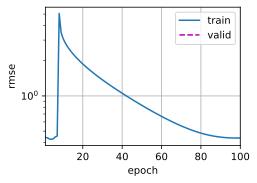

In [69]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')